In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import ConfusionMatrixDisplay

from imblearn.over_sampling import SMOTE

# For reproducibility
RANDOM_STATE = 42

In [4]:
file_path = "/kaggle/input/loan-approval-prediction-dataset/loan_approval_dataset.csv"
df = pd.read_csv(file_path)

print("Dataset shape:", df.shape)
display(df.head())


Dataset shape: (4269, 13)


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [5]:
# EDA and target inspection
print("Columns:\n", df.columns.tolist())
print("\nMissing values per column:")
print(df.isnull().sum())

df.columns = df.columns.str.strip()

print("\nTarget distribution (loan_status):")
print(df['loan_status'].value_counts(dropna=False))

# If loan_status is string like 'Y'/'N' or 'Approved'/'Rejected', show unique values
print("\nUnique target values:", df['loan_status'].unique())


Columns:
 ['loan_id', 'no_of_dependents', 'education', 'self_employed', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value', 'loan_status']

Missing values per column:
loan_id                     0
no_of_dependents            0
education                   0
self_employed               0
income_annum                0
loan_amount                 0
loan_term                   0
cibil_score                 0
residential_assets_value    0
commercial_assets_value     0
luxury_assets_value         0
bank_asset_value            0
loan_status                 0
dtype: int64

Target distribution (loan_status):
loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64

Unique target values: [' Approved' ' Rejected']


In [6]:
# Fill numerical missing values with median
# Fill categorical missing values with mode
# Map loan_status to binary (0/1) if needed

# Make a copy for processing
data = df.copy()

# If loan_status is not numeric, convert common labels to 0/1
if data['loan_status'].dtype == object:
    # common variants: 'Y'/'N', 'Yes'/'No', 'Approved'/'Rejected', 1/0 as strings
    mapping = {}
    uniques = [str(x).strip().lower() for x in data['loan_status'].unique()]
    # heuristics:
    if any(u in ['y','yes','approved','1','true','approved '] for u in uniques):
        # Map likely positive values to 1 and others to 0
        # We'll map strings containing 'y', 'yes', 'approve', '1', 'true' -> 1
        def map_status(x):
            s = str(x).strip().lower()
            if any(k in s for k in ['y','yes','approve','1','true']):
                return 1
            else:
                return 0
        data['loan_status'] = data['loan_status'].apply(map_status)
    else:
        # If already numeric-like, try to convert
        data['loan_status'] = pd.to_numeric(data['loan_status'], errors='coerce')

# Ensuring target is integer 0/1
data = data.dropna(subset=['loan_status']).reset_index(drop=True)
data['loan_status'] = data['loan_status'].astype(int)

print("After mapping, target distribution:")
print(data['loan_status'].value_counts())


After mapping, target distribution:
loan_status
1    2656
0    1613
Name: count, dtype: int64


In [7]:
feature_cols = [
    "no_of_dependents",
    "education",
    "self_employed",
    "income_annum",
    "loan_amount",
    "loan_term",
    "cibil_score",
    "residential_assets_value",
    "commercial_assets_value",
    "luxury_assets_value",
    "bank_asset_value"
]
target_col = "loan_status"

X = data[feature_cols].copy()
y = data[target_col].copy()

# Identify numeric and categorical features
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = [c for c in feature_cols if c not in numeric_features]

print("Numeric features:", numeric_features)
print("Categorical features:", categorical_features)


Numeric features: ['no_of_dependents', 'income_annum', 'loan_amount', 'loan_term', 'cibil_score', 'residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']
Categorical features: ['education', 'self_employed']


In [8]:
# Numeric pipeline: median imputation + scaling
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Categorical pipeline: most frequent imputation + one-hot encoding (drop='first' to avoid multicollinearity)
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', drop='first'))
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# Fit-transform example to check output shape (optional)
preprocessor.fit(X)
print("Preprocessor fitted.")


Preprocessor fitted.


In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts(normalize=True))
print("Test target distribution:\n", y_test.value_counts(normalize=True))


Train shape: (3415, 11) Test shape: (854, 11)
Train target distribution:
 loan_status
1    0.622255
0    0.377745
Name: proportion, dtype: float64
Test target distribution:
 loan_status
1    0.62178
0    0.37822
Name: proportion, dtype: float64


--- Logistic Regression (baseline) ---
Precision: 0.9209558823529411
Recall:    0.943502824858757
F1-score:  0.932093023255814

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.87      0.88       323
           1       0.92      0.94      0.93       531

    accuracy                           0.91       854
   macro avg       0.91      0.91      0.91       854
weighted avg       0.91      0.91      0.91       854



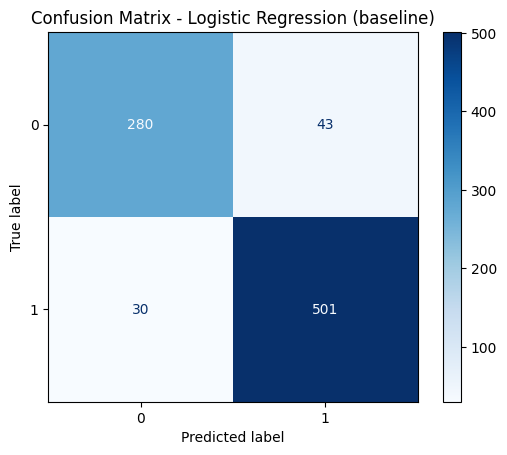

--- Decision Tree (baseline) ---
Precision: 0.983177570093458
Recall:    0.9905838041431262
F1-score:  0.9868667917448405

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.97      0.98       323
           1       0.98      0.99      0.99       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



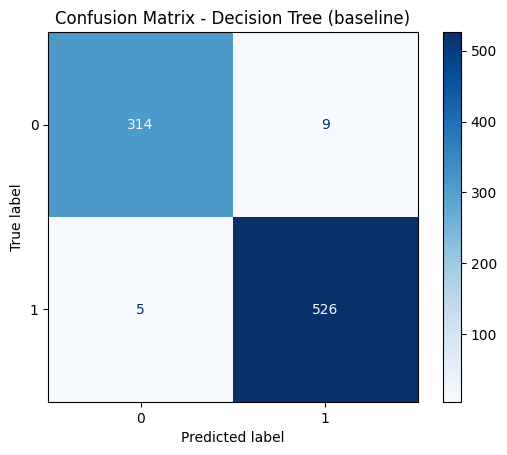

In [10]:
# Baseline pipelines (no SMOTE)
# Pipeline for Logistic Regression
pipe_log = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

# Pipeline for Decision Tree
pipe_dt = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Train models
pipe_log.fit(X_train, y_train)
pipe_dt.fit(X_train, y_train)

# Predictions
y_pred_log = pipe_log.predict(X_test)
y_pred_dt = pipe_dt.predict(X_test)

# Evaluation helper
def eval_model(y_true, y_pred, model_name):
    print(f"--- {model_name} ---")
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall:   ", recall_score(y_true, y_pred, zero_division=0))
    print("F1-score: ", f1_score(y_true, y_pred, zero_division=0))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()

# Evaluate baseline
eval_model(y_test, y_pred_log, "Logistic Regression (baseline)")
eval_model(y_test, y_pred_dt, "Decision Tree (baseline)")


Processed train shape: (3415, 11) Processed test shape: (854, 11)
After SMOTE - class distribution: loan_status
1    2125
0    2125
Name: count, dtype: int64
--- Logistic Regression (SMOTE) ---
Precision: 0.9496124031007752
Recall:    0.9227871939736346
F1-score:  0.936007640878701

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.92      0.90       323
           1       0.95      0.92      0.94       531

    accuracy                           0.92       854
   macro avg       0.91      0.92      0.92       854
weighted avg       0.92      0.92      0.92       854



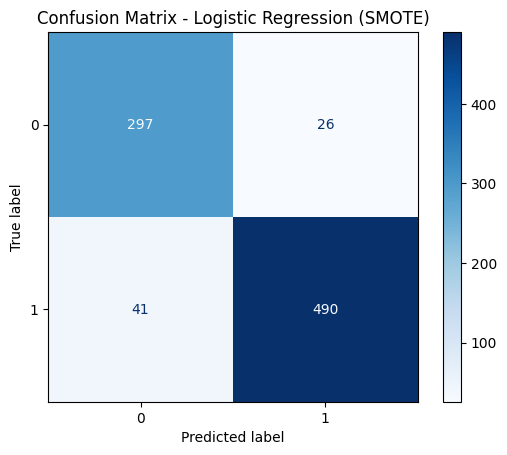

--- Decision Tree (SMOTE) ---
Precision: 0.9849906191369606
Recall:    0.9887005649717514
F1-score:  0.9868421052631579

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       323
           1       0.98      0.99      0.99       531

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854



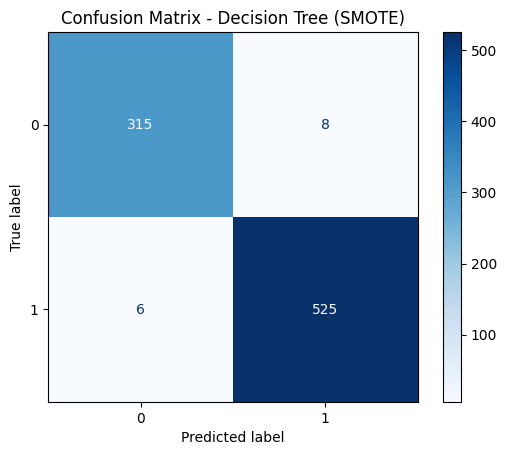

In [11]:
# Address imbalance with SMOTE (applying SMOTE on training set only)
# Preprocess training data to numeric array, then apply SMOTE, then train classifier on resampled data

# 1) Transform X_train with preprocessor (fit already) -> array
X_train_proc = preprocessor.transform(X_train)
X_test_proc = preprocessor.transform(X_test)

print("Processed train shape:", X_train_proc.shape, "Processed test shape:", X_test_proc.shape)

# 2) Apply SMOTE
sm = SMOTE(random_state=RANDOM_STATE)
X_res, y_res = sm.fit_resample(X_train_proc, y_train)

print("After SMOTE - class distribution:", pd.Series(y_res).value_counts())

# 3) Train models on resampled data
log_sm = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
dt_sm = DecisionTreeClassifier(random_state=RANDOM_STATE)

log_sm.fit(X_res, y_res)
dt_sm.fit(X_res, y_res)

# 4) Predict on original test set (never resample test set)
y_pred_log_sm = log_sm.predict(X_test_proc)
y_pred_dt_sm = dt_sm.predict(X_test_proc)

# Evaluate SMOTE results
eval_model(y_test, y_pred_log_sm, "Logistic Regression (SMOTE)")
eval_model(y_test, y_pred_dt_sm, "Decision Tree (SMOTE)")


,Model,Precision,Recall,F1
0,Logistic (baseline),0.920956,0.943503,0.932093
1,Logistic (SMOTE),0.949612,0.922787,0.936008
2,DecisionTree (baseline),0.983178,0.990584,0.986867
3,DecisionTree (SMOTE),0.984991,0.988701,0.986842


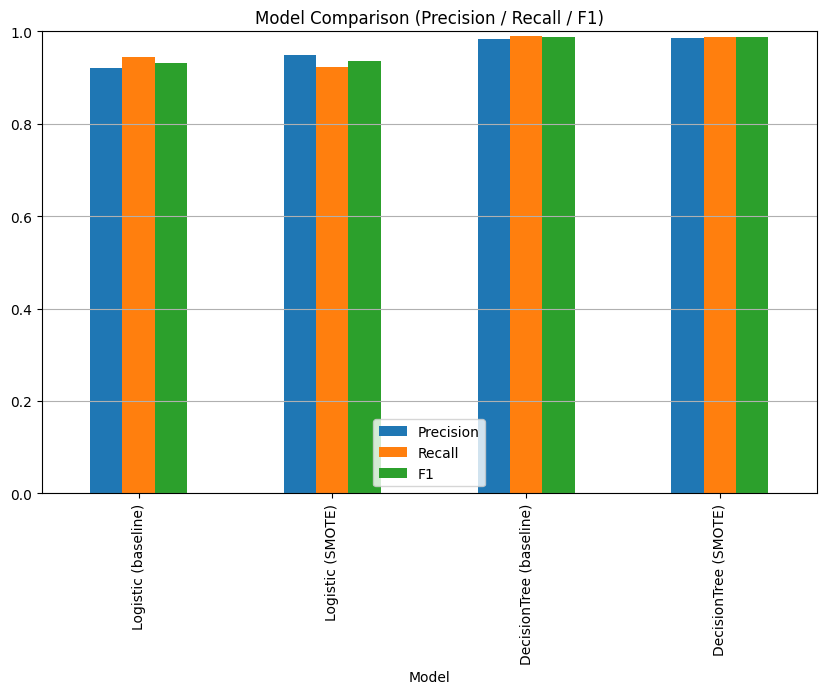

In [13]:
# Comparison summary table (baseline vs SMOTE)
from sklearn.metrics import precision_score, recall_score, f1_score

results = []

# Baseline scores
results.append({
    'Model': 'Logistic (baseline)',
    'Precision': precision_score(y_test, y_pred_log, zero_division=0),
    'Recall': recall_score(y_test, y_pred_log, zero_division=0),
    'F1': f1_score(y_test, y_pred_log, zero_division=0)
})

# SMOTE scores
results.append({
    'Model': 'Logistic (SMOTE)',
    'Precision': precision_score(y_test, y_pred_log_sm, zero_division=0),
    'Recall': recall_score(y_test, y_pred_log_sm, zero_division=0),
    'F1': f1_score(y_test, y_pred_log_sm, zero_division=0)
})
results.append({
    'Model': 'DecisionTree (baseline)',
    'Precision': precision_score(y_test, y_pred_dt, zero_division=0),
    'Recall': recall_score(y_test, y_pred_dt, zero_division=0),
    'F1': f1_score(y_test, y_pred_dt, zero_division=0)
})

results.append({
    'Model': 'DecisionTree (SMOTE)',
    'Precision': precision_score(y_test, y_pred_dt_sm, zero_division=0),
    'Recall': recall_score(y_test, y_pred_dt_sm, zero_division=0),
    'F1': f1_score(y_test, y_pred_dt_sm, zero_division=0)
})

results_df = pd.DataFrame(results)
display(results_df)

# Simple bar plot
results_df.set_index('Model')[['Precision','Recall','F1']].plot(kind='bar', figsize=(10,6))
plt.title("Model Comparison (Precision / Recall / F1)")
plt.ylim(0,1)
plt.grid(axis='y')
plt.show()
